#Задача 1

$p(w| X_{train},y_{train},A) = \frac{p(y_{train}| w, X_{train}, A) p(w|A)}{\int p(w^*, y_{train}| X_{train}, A)dw^*} $

$p(w| X_{train},y_{train},A) \sim p(y_{train}| w, X_{train}, A) p(w|A)$

$q(w) = \ln p(w| X_{train},y_{train},A) = \ln p(w, y_{train}| X_{train}, A) + \ln p(w|A) + const = \sum\limits_{i=1}^{m_1}\ln\left( p_i^{y_i}(1-p_i)^{(1-y_i)}  \right) - \frac{1}{2}w^TAw + const = \sum\limits_{i=1}^{m_1}y_i\ln p_i + (1-y_i)\ln (1-p_i)   - \frac{1}{2}w^TAw + const$

где $p_i(w) = \sigma(w^Tx_i)$

$\nabla^2 q(w) = \sum\limits_{i=1}^{m_1}p_i(1-p_i)x_ix_i^T + A$

Значит, его нормальная апроксимация в точке $w_0$: $N(w_0, H_0^{-1}), H_0 = \sum\limits_{i=1}^{m_1}\sigma(w_0^Tx_i)\cdot(1-\sigma(w_0^Tx_i))\cdot x_ix_i^T  + A$



In [1]:
from scipy.stats import multivariate_normal
from scipy.stats import bernoulli
import numpy as np
from scipy.special import expit
from scipy import integrate
from scipy.optimize import fmin
from scipy.stats import binom
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.special
import math

In [2]:
n = 50
m2 = 1000
sigma = 1
A = np.identity(n)

In [3]:
m1 = 100
X1 = multivariate_normal.rvs(mean = None, cov = sigma * np.identity(n), size = m1)
X2 = multivariate_normal.rvs(mean = None, cov = sigma * np.identity(n), size = m2)

w_real = multivariate_normal.rvs(mean = None, cov = A, size = 1)

p_list1 = np.array([1/(1+np.exp(-w_real.dot(X1[i]))) for i in range(m1)])
p_list2 = np.array([1/(1+np.exp(-w_real.dot(X2[i]))) for i in range(m2)])

y1 = np.array([bernoulli.rvs(p, size=1)[0] for p in p_list1])
y2 = np.array([bernoulli.rvs(p, size=1)[0] for p in p_list2])

In [4]:
def H0_(w0, X, A):
  n = w0.shape[0]
  H0 = np.zeros((n, n))
  z = X.dot(w0)
  v = expit(z)*(1-expit(z))
  for i, xi in enumerate(X):
    xi = xi.reshape((n, 1))
    H0 = H0 + v[i]*xi.dot(xi.T)
  return (H0 + A)

def C_(p):
  return np.sum(abs(p-0.5))

def l_(y, p):
  return np.prod(p**y*(1-p)**(1-y))

def l_log(y, p):
  return np.sum(y*np.log(p) + (1-y)*np.log(1-p))

def q_(w, X, y):
  p = p_(w, X, y)
  summ = np.sum(y*np.log(p) + (1-y)*np.log(1-p))
  return -summ + A.dot(w).dot(w)

def p_(w, X, y):
  return np.array([expit(w.dot(xi)) if yi == 1 else expit(-w.dot(xi)) for xi,yi in zip(X,y)])

def p_y_wX_(y1, w, X1):
  p = p_(w, X1, y1)
  return l_(y1, p)

def p_w_A_(w, A):
  return multivariate_normal.pdf(w, mean = None, cov = A)

def p_yw_XA_(y1, w, X1, A):
  return p_y_wX_(y1, w, X1) * p_w_A_(w, A)

def C_y_XA_(y1, X1, A):
  f = lambda *w: p_yw_XA_(y1, np.array(w), X1, A)
  return integrate.nquad(f, [[-np.inf, np.inf]]*n)[0]

def C_y_XA_fast(y1, X1, A):
  f = lambda *w: p_yw_XA_(y1, np.array(w), X1, A)
  return integrate.nquad(f, [[-np.inf, np.inf]]*n)[0]

def get_wmap(X1, y1):
  clf = LogisticRegression(C=2., penalty='l2', tol=0.00001, fit_intercept = False)
  clf.fit(X1, y1)
  return clf.coef_[0]

def p_base(X1, y1, X2):
  w = get_wmap(X1, y1)
  p = expit(-X2.dot(w))
  return p

def p_mod(X1, y1, X2):
  C = C_y_XA_(y1, X1, A)
  p = np.zeros(m2)
  for i,x in enumerate(X2):
    f = lambda *w: expit(x.dot(np.array(w))) * p_yw_XA_(y1,  np.array(w), X1, A)
    p[i] = integrate.nquad(f, [[-np.inf, np.inf]]*n)[0]/C
  return p

def p_mod_fast(X1, y1, X2):
  w0 = get_wmap(X1, y1)
  H0 = H0_(w0, X1, A)
  w = multivariate_normal.rvs(mean = w0, cov = np.linalg.inv(H0), size = 10000)
  p = expit(-X2.dot(w.T))
  p = np.mean(p, axis=1)
  return p

In [6]:
m1_list = [5, 10, 15, 20, 30, 40, 60, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
Cb_list = []
Cm_list = []
lb_list = []
lm_list = []



for m1 in m1_list:
  X1 = multivariate_normal.rvs(mean = None, cov = sigma * np.identity(n), size = m1)
  X2 = multivariate_normal.rvs(mean = None, cov = sigma * np.identity(n), size = m2)

  w_real = multivariate_normal.rvs(mean = None, cov = A, size = 1)

  p_list1 = np.array([1/(1+np.exp(-w_real.dot(X1[i]))) for i in range(m1)])
  p_list2 = np.array([1/(1+np.exp(-w_real.dot(X2[i]))) for i in range(m2)])

  y1 = np.array([bernoulli.rvs(p, size=1)[0] for p in p_list1])
  y2 = np.array([bernoulli.rvs(p, size=1)[0] for p in p_list2])

  p_b = p_base(X1, y1, X2)
  Cb_list.append(C_(p_b))
  lb_list.append(l_log(y2, p_b))

  p_m = p_mod_fast(X1, y1, X2)
  Cm_list.append(C_(p_m))
  lm_list.append(l_log(y2, p_m))

уверенность C


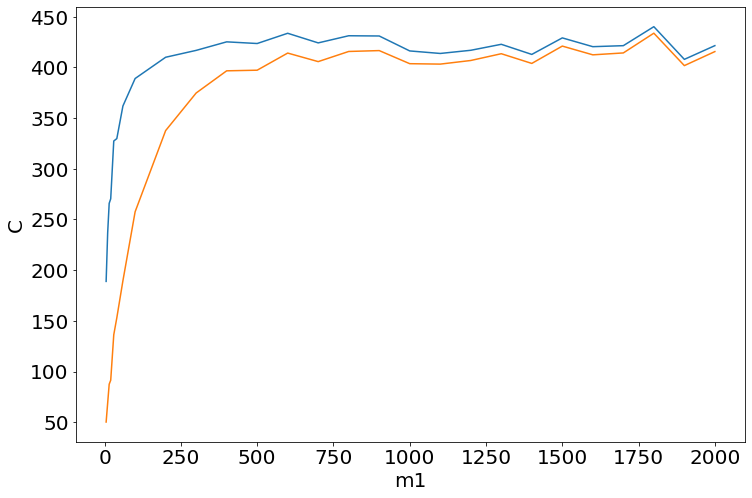

In [7]:
plt.figure(figsize=(12, 8))
fontsize=20

ax = plt.axes()
plt.xlabel(r"m1", fontsize=fontsize)
plt.ylabel(r"C", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

ax.plot(m1_list, Cb_list)
ax.plot(m1_list, Cm_list)
print('уверенность C')

правдоподобие l


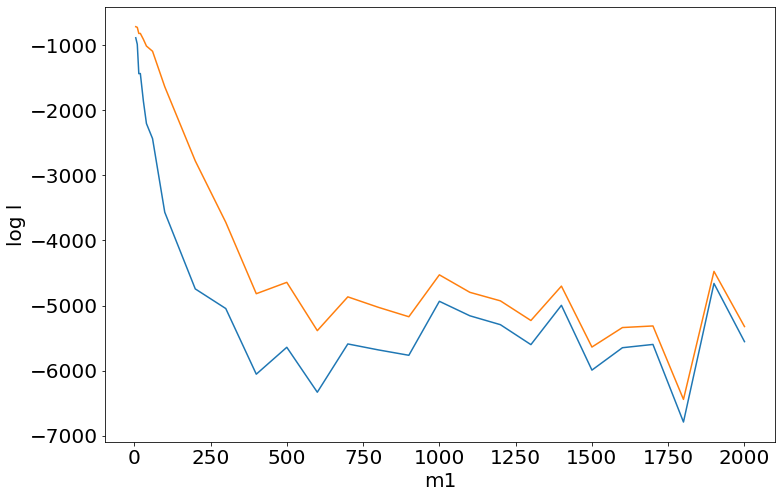

In [8]:
plt.figure(figsize=(12, 8))
fontsize=20

ax = plt.axes()
plt.xlabel(r"m1", fontsize=fontsize)
plt.ylabel(r"log l", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

ax.plot(m1_list, lb_list)
ax.plot(m1_list, lm_list)
print('правдоподобие l')

Правдоподбие полного классифкатора больше, чем точечного, но при больших размерах обучающей выборки разница стремиться к $0$. Практический вывод: при больших объемах данных можно пользоваться точеченым классификатором, что вычислительно легче и результат будет совпадать с полным классификатором.

#Задача 2

a) $y = Xw+\epsilon, \epsilon\sim N(0,\sigma^2 I_n)$

$p(y,w|X,m,s) = p(y|w,X,m,s)p(w|X,m,s)=p(y|w,X)p(w|m,s)$

$p(y|w,X)= \frac{1}{(2\pi)^{n/2}\sigma^n}\exp\left(-\frac{1}{2\sigma^2}||y-Xw||^2 \right)$

$S = diag(s)$

$p(w|m,s) = N(w|m, diag(s)) = \frac{1}{(2\pi)^{n/2}\sigma^n}\exp\left(-\frac{1}{2}(w-m)^T S^{-1}(w-m) \right)$

б) $p(w|y,X,m,s) = \frac{p(y,w|X,m,s)}{p(y|X,m,s)} = \frac{p(y|w,X)p(w|m,s)}{\int p(y|w^*,X)p(w^*|m,s)dw^*}$

$\log p(y|w,X)p(w|m,s) = \log p(y|w,X)+\log p(w|m,s) 
= -\frac{1}{2\sigma^2}||y-Xw||^2 - \frac{1}{2}(w-m)^T S^{-1}(w-m) 
= -\frac{1}{2\sigma^2}||y||^2+\frac{1}{\sigma^2}y^TXw-\frac{1}{2\sigma^2}w^TX^TXw-\frac{1}{2}w^T S^{-1} w + m^T S^{-1} w -\frac{1}{2} m^T S^{-1} m 
= -\frac{1}{2}w^T(\frac{1}{\sigma^2}X^TX+S^{-1})w + (\frac{1}{\sigma^2}y^TX+m^TS^{-1})w + const = -\frac{1}{2}(w-v)^T\Sigma^{-1}(w-v)
= -\frac{1}{2}w^T\Sigma^{-1}w + v^T\Sigma^{-1}w + const$

$v^T = (\frac{1}{\sigma^2}y^TX+m^TS^{-1})\Sigma
= (\frac{1}{\sigma^2}y^TX+m^TS^{-1})(\frac{1}{\sigma^2}X^TX+S^{-1})^{-1}$

$\Sigma = (\frac{1}{\sigma^2}X^TX+S^{-1})^{-1}$

$v = (\frac{1}{\sigma^2}X^TX+S^{-1})^{-1}(\frac{1}{\sigma^2}X^Ty+S^{-1}m)$

Таким образом, $p(w|y,X,m,s) = N(v,\Sigma)$



Если $s_i = 0$, тогда $\Sigma_{ii} = 0$, что означает, что мы точно знаем значение $w_i$. Это ожидаемо, потому что $s_i=0$ означает нашу полную уверенность в априорном значении $w_i$, и апостериорное значение должно остаться таким же. 

в) $p(y|X,m,s) = \int p(y|w,X) p(w|m, s)dw = const \cdot \int f(y-Xw\ |\ 0, \ \sigma^2 I_n) \cdot f(w\ |\ m,\ S)dw = const \cdot \int f(w\ |\ (X^TX)^{-1}Xy,\ \sigma^2 (X^TX)^{-1})\cdot f(w\ |\ m,\ S)dw$


#Задача 3

а) $q(p,k|n) = q(k|p,n)q(p|n)$

Правдоподиe бросаний монет:

$q(k|p,n) = Bin(n,p) = C_{n}^{k}p^{k}(1-p)^{n-k}$

Полное правдоподобие:

$q(k_1, k_2|p_1, p_2 , n_1, n_2) = q(k_1|p_1,n_1)q(k_2|p_2,n_2)$

Априорное распределение:

$q(p) = N\left(\frac{1}{2},\frac{1}{4}\right) =  \frac{2}{\sqrt{2\pi}}\exp\left(-2(p-\frac{1}{2})^2 \right), p\in [0,1]$

Оно выбрана таким, поскольку, как правило, монетки правильные, либо вероятность орла совсем немного отклоняются от $\frac{1}{2}$, причем причин, по которым происходит отклонение (небольшой брак и тп), много и их можно считать независымыми, а значит хорошо апроксимируются нормальным распределением. Оно не должно быть слишком узким, поскольку я сомневаюсь в том, что она правильная.

б) $q(p|k,n) = \frac{q(k|p,n)q(p)}{\int q(k|p,n)q(p)dp}$

в) $q(k_1, k_2|M_1, n_1, n_2) = \int q(k_1, k_2, p|M_1, n_1, n_2)dp =\int q(k_1|p,n_1)q(k_2|p,n_2)q(p)dp$

$q(k_1, k_2|M_2, n_1, n_2) = \int\int q(k_1, k_2, p_1, p_2|M_2, n_1, n_2) dp_1dp_2 = \int\int q(k_1|p_1,n_1)q(k_2|p_2,n_2)q(p_1)q(p_2)dp_1dp_2 $

 
$q(k_1, k_2|n_1, n_2) = q(M_1)q(k_1, k_2|M_1, n_1, n_2) + q(M_2)q(k_1, k_2|M_2, n_1, n_2)$

In [38]:
def q_k_pn_(k, p, n):
  res = np.zeros(p.shape)
  for i, pi in enumerate(p):
    res[i] = binom(n, pi).pmf(k)
  return res

def intege_M1(k1,k2,n1,n2):
  size = 100000
  p = norm.rvs(loc = 1/2, scale = (1/6)**2, size = size)
  p[p < 0] = 0
  p[p > 1] = 1
  integr = q_k_pn_(k1, p, n1)*q_k_pn_(k2, p, n2)
  integr = np.mean(integr, axis=0) 
  return integr

def intege_M2(k1,k2,n1,n2):
  size = 100000
  p1 = norm.rvs(loc = 1/2, scale = (1/6)**2, size = size)
  p2 = norm.rvs(loc = 1/2, scale = (1/6)**2, size = size)
  p1[p1 < 0] = 0
  p1[p1 > 1] = 1
  p2[p2 < 0] = 0
  p2[p2 > 1] = 1
  integr = q_k_pn_(k1, p1, n1)*q_k_pn_(k2, p2, n2)
  integr = np.mean(integr, axis=0) 
  return integr

In [39]:
apr_M1 = apr_M2 = 0.5
k1 = 3
n1 = 10
k2 = 5050
n2 = 10000

_apost_M1 = intege_M1(k1,k2,n1,n2)
_apost_M2 = intege_M2(k1,k2,n1,n2)

apost_M1 = apr_M1*_apost_M1/(apr_M1*_apost_M1+apr_M2*_apost_M2)
apost_M2 = apr_M2*_apost_M2/(apr_M1*_apost_M1+apr_M2*_apost_M2)

print(apost_M1, apost_M2)

0.4874571488493665 0.5125428511506335


#Задача 4

а) Дивергенция Кульбака-Лейблера распределения $\displaystyle Q$ относительно $\displaystyle P$ --- это величина потерь информации при замене истинного распределения $\displaystyle P$ на распределение $\displaystyle Q$, которая может служить несиммитричной мерой различия двух распределений.

$\displaystyle D_{\mathrm {KL} }(P\parallel Q)=\int _{X}p(x)\,\log {\frac {p(x)}{q(x)}}\,{\rm {d}}x $

б) Для всех $z>0$ выполненно $\ln z \leq z-1$

$ D_{\mathrm {KL} }(P\parallel Q) = \int _{X}p(x)\,\ln {\frac {p(x)}{q(x)}}\,{\rm {d}}x = -\int _{X}p(x)\,\ln {\frac {q(x)}{p(x)}}\,{\rm {d}}x \geq -\int _{X}p(x)\,\left( {\frac {q(x)}{p(x)}} - 1\right)\,{\rm {d}}x = -\int _{X}\,q(x)\,{\rm {d}}x + \int _{X}\,p(x)\,{\rm {d}}x = 0$

в) В этой задаче все упирается в размеры выборок. Вторая модель имеет большую дисперсию в апостериорном распределении $w_2$, что может говорить о маленькой размере выборки. Если во второй выборке всего пару элементов, а настоящее $w_2 = (1,1)$, тогда мы могли бы запросто получить такое апостериорное распределение на $w_2$. Плотность распределения $w_2$ в точке $(-2, -3)$ почти не отличается от плотности в точке $(1,1)$, поэтому сказать, что $w_1$ и $w_2$ нельзя.

Можно посчитать дивергенцию Кульбака-Лейблера по формуле для нормальных распределений:

$ D_{\mathrm {KL} }(N_0\parallel N_1) = \frac{1}{2}\left( tr(\Sigma_1^{-1}\Sigma_0) + (m_1-m_0)^T\Sigma_1^{-1}(m_1-m_0)-k+\ln\left( \frac{det\Sigma_1}{det\Sigma_0}\right)\right)$

In [11]:
def kl_mvn(m0, S0, m1, S1):
    """
    Kullback-Liebler divergence from Gaussian pm,pv to Gaussian qm,qv.
    Also computes KL divergence from a single Gaussian pm,pv to a set
    of Gaussians qm,qv.
    Diagonal covariances are assumed.  Divergence is expressed in nats.

    - accepts stacks of means, but only one S0 and S1

    From wikipedia
    KL( (m0, S0) || (m1, S1))
         = .5 * ( tr(S1^{-1} S0) + log |S1|/|S0| + 
                  (m1 - m0)^T S1^{-1} (m1 - m0) - N )
    """
    # store inv diag covariance of S1 and diff between means
    N = m0.shape[0]
    iS1 = np.linalg.inv(S1)
    diff = m1 - m0

    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print(tr_term,det_term,quad_term)
    return .5 * (tr_term + det_term + quad_term - N)  

In [12]:
kl_mvn(np.array([-2,-3]), 100*np.identity(2), np.array([1,1]), 1*np.identity(2))  

106.89482981401191

In [13]:
kl_mvn(np.array([1,1]), 1*np.identity(2), np.array([-2,-3]), 100*np.identity(2)) 

3.7401701859880916

Значение дивергенции велико, что означает большое отличие этих распределений, но это не значит, что мы можем с уверенностью утверждать, что $w_1, w_2$ разные.